In [1]:
%load_ext autoreload
%autoreload 2

from pandas_profiling import ProfileReport
%pylab inline

import warnings
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
df_train = pd.read_csv('./data/train_2016_v2.csv')

In [3]:
dtypes = {
    'parcelid': int,
    'airconditioningtypeid': str,
    'architecturalstyletypeid': str,
    'buildingclasstypeid': str,
    'buildingqualitytypeid': str,
    'decktypeid': str,
    'heatingorsystemtypeid': str,
    'pooltypeid10': str,
    'pooltypeid2': str,
    'pooltypeid7': str,
    'regionidcity': str,
    'regionidcounty': str,
    'regionidneighborhood': str,
    'regionidzip': str,
    'typeconstructiontypeid': str,
    'hashottuborspa': str,
    'propertycountylandusecode': str,
    'propertylandusetypeid': str,
    'propertyzoningdesc': str,
    'rawcensustractandblock': str,
    'fireplaceflag': str,
    'taxdelinquencyflag': str,
    'censustractandblock': str,
}

props_df = pd.read_csv('./data/properties_2016.csv', dtype=dtypes)

dtypes.update({
    'fireplacecnt': int,
    'fullbathcnt': int,
    'garagecarcnt': int,
    'poolcnt': int,
    'threequarterbathnbr': int,
    'unitcnt': int,
    'yearbuilt': int,
    'numberofstories': int,
    'structuretaxvaluedollarcnt': int,
    'taxvaluedollarcnt': int,
    'landtaxvaluedollarcnt': int,
    'taxdelinquencyyear': int,
    'roomcnt': int,
    'bedroomcnt': int,
    'assessmentyear': int,
    'fips': int,
})

In [4]:
df_train = df_train.merge(props_df, on='parcelid', how='left')
df_train.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1,NaN,NaN,2.0,3.0,NaN,4,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,60371066461001
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1,NaN,NaN,3.0,2.0,NaN,4,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,60374638003004
3,12643413,0.0218,2016-01-02,1,NaN,NaN,2.0,2.0,NaN,4,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,60372963002002
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,60590423381006


In [7]:
df_train['transactiondate'] = pd.to_datetime(df_train.transactiondate)

In [20]:
df_train['transactionmonth'] = df_train.transactiondate.dt.month
df_train['transactionweek'] = df_train.transactiondate.dt.week
df_train['transactionweekofyear'] = df_train.transactiondate.dt.weekofyear
df_train['transactionday'] = df_train.transactiondate.dt.day
df_train['transactiondayofweek'] = df_train.transactiondate.dt.dayofweek
df_train['transactiondayofyear'] = df_train.transactiondate.dt.dayofyear
df_train['transactionyear'] = df_train.transactiondate.dt.year
df_train['transactionyearmonth'] = df_train.transactiondate.dt.year.astype(str) + df_train.transactiondate.dt.month.astype(str)

In [24]:
df_train['transactionyear'].value_counts()

2016    90275
Name: transactionyear, dtype: int64

/home/mtambos/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=2016.0, right=2016.0
  'left=%s, right=%s') % (left, right))


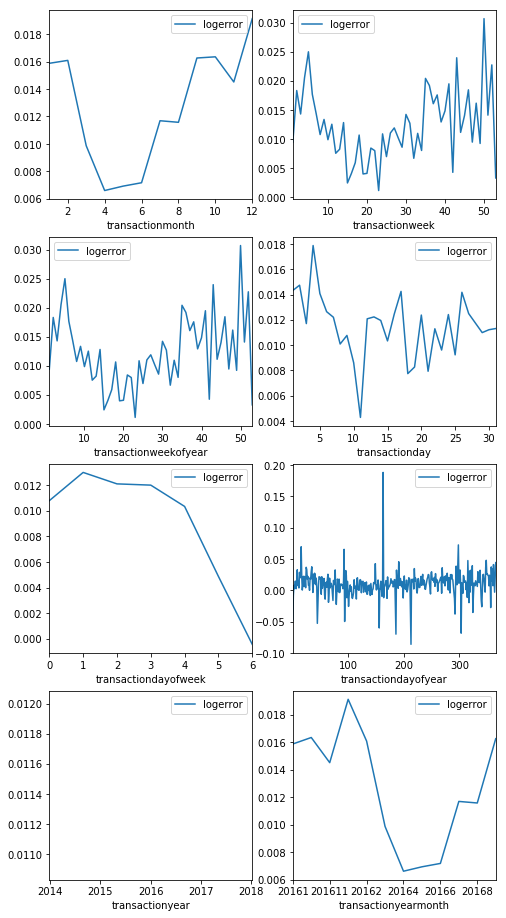

In [23]:
_, axes = plt.subplots(4, 2, figsize=(8, 16))
axes = axes.flatten()
df_train[['transactionmonth', 'logerror']].groupby('transactionmonth').mean().plot(ax=axes[0])
df_train[['transactionweek', 'logerror']].groupby('transactionweek').mean().plot(ax=axes[1])
df_train[['transactionweekofyear', 'logerror']].groupby('transactionweekofyear').mean().plot(ax=axes[2])
df_train[['transactionday', 'logerror']].groupby('transactionday').mean().plot(ax=axes[3])
df_train[['transactiondayofweek', 'logerror']].groupby('transactiondayofweek').mean().plot(ax=axes[4])
df_train[['transactiondayofyear', 'logerror']].groupby('transactiondayofyear').mean().plot(ax=axes[5])
df_train[['transactionyear', 'logerror']].groupby('transactionyear').mean().plot(ax=axes[6])
df_train[['transactionyearmonth', 'logerror']].groupby('transactionyearmonth').mean().plot(ax=axes[7])